In [222]:
from transformers import AutoTokenizer, AutoModel

from sklearn.decomposition import PCA

import torch

import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import pandas as pd
import numpy as np
import re
import seaborn as sns

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.61 s (started: 2021-05-20 14:21:22 +03:00)


# 1. Кастомные функции

## 1.1 Получить слова из текста в нужном формате

Берется файл с аналогиями, переводится в нужный вид, с которым будут работать в дальнейшем функции

In [15]:
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

time: 0 ns (started: 2021-05-20 00:56:43 +03:00)


In [62]:
def get_analogy_words(filename):
    
    with open(filename, encoding='utf-8') as f:
        content = f.readlines()
    
    words_to_agg = [x.strip() for x in content] 
    
    words_to_agg = " ".join(words_to_agg)
    words_to_agg = " ".join(words_to_agg.split('_'))
    
    stop_words = ['PROPN', 'ADJ', 'VERB','ADV', 'NOUN']
    
    for i in stop_words:
        words_to_agg = words_to_agg.replace(i, '')
    
    words_to_agg = words_to_agg.replace('й','и')
    
    words_to_agg = ' '.join(unique_list(words_to_agg.split()))
    
    return words_to_agg

time: 0 ns (started: 2021-05-20 01:40:25 +03:00)


In [17]:
file1 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\столица-страна.txt'

anal1 = get_analogy_words(file1)

anal1

'афины греция багдад ирак бангкок таиланд пекин китай берлин германия берн швейцария каир египет канберра австралия ханой вьетнам гавана куба хельсинки финляндия исламабад пакистан кабул афганистан лондон англия мадрид испания москва россия осло норвегия оттава канада париж франция рим италия стокгольм швеция тегеран иран токио япония'

time: 0 ns (started: 2021-05-20 00:56:44 +03:00)


In [18]:
file2 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\adj-NOTadj.txt'

anal2 = get_analogy_words(file2)

anal2

'приемлемый неприемлемый простой непростой определенный неопределенный ясный неясный удобный неудобный конкурентноспособный неконкурентноспособный последовательный непоследовательный убедительный неубедительный решенный нерешенный эффективный неэффективный этичный неэтичный удачный неудачный честный нечестный уместный неуместный информативный неинформативный осведомленный неосведомленный известный неизвестный вероятный невероятный логичный нелогичный приятный неприятный возможный невозможный продуктивный непродуктивный рациональный иррациональный разумный неразумный ответственный безответственный уверенный неуверенный благодарный неблагодарный'

time: 16 ms (started: 2021-05-20 00:57:28 +03:00)


## 1.2 Получить эмбеддинги BERT

In [228]:
def get_embeddings(tokenizer, model, words_to_embed):
    """
    Функция возвращает таблицу с эмбеддингами каждого слова.
    
    Parameters
    ----------
    tokenizer : transformers.models.bert.tokenization_bert_fast.BertTokenizerFast
        Предобученный токенизатор BERT
    
    model : transformers.models.bert.modeling_bert.BertModel
        Предобученная модель BERT
    
    words_to_embed : str
        Слова, переданные в виде одной строки, идущие через пробел.
        
    Returns
    -------
    table_embedding : pd.Dataframe
        Табличка с эмбеддингами каждого слова из `words_to_embed`
    
    """
    
    # Add the special tokens.
    marked_text = "[CLS] " + words_to_embed + " [SEP]"

    # Split the sentence into tokens.
    tokenized_text = tokenizer.tokenize(marked_text)

    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [1] * len(tokenized_text)
    
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    # Run the text through BERT, and collect all of the hidden states produced
    # from all 12 layers. 
    with torch.no_grad():

        outputs = model(tokens_tensor, segments_tensors)

        # Evaluating the model will return a different number of objects based on 
        # how it's  configured in the `from_pretrained` call earlier. In this case, 
        # becase we set `output_hidden_states = True`, the third item will be the 
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]
        
    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddings = torch.stack(hidden_states, dim=0)
    
    # Remove dimension 1, the "batches".
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    
    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(1,0,2)

    # Stores the token vectors, with shape [22 x 768]
    token_vecs_sum = []

    # `token_embeddings` is a [22 x 12 x 768] tensor.
    
    # For each token in the sentence...
    for token in token_embeddings:

        # `token` is a [12 x 768] tensor

        # Sum the vectors from the last four layers.
        sum_vec = torch.sum(token[-4:], dim=0)
    
        # Use `sum_vec` to represent `token`.
        token_vecs_sum.append(sum_vec)
    
    word_ids = []

    for i in range(len(tokenized_text)):
        if (tokenized_text[i] in words_to_embed.lower()):
            word_ids.append(i)
    
    words_embs = {}

    for i in range(len(word_ids)):
        words_embs[words_to_embed.lower().split()[i]] = token_vecs_sum[word_ids[i]]
    
    table_embedding = pd.DataFrame()
    for word in words_to_embed.lower().split():
        table_embedding = table_embedding.append(pd.Series(words_embs[word]),ignore_index=True)

    table_embedding.index = words_to_embed.lower().split()
    
    return table_embedding

time: 16 ms (started: 2021-05-20 14:30:01 +03:00)


## 1.3 Решить задачу аналогии методом 3CosAdd

In [23]:
def solve_analogy_3CosAdd(words_to_embed, words_embeddings):
    
    index_list = np.arange(0,len(words_to_embed.split()))
    evensList = [x for x in index_list if x % 2 == 0]
    index_list =  np.arange(0,len(evensList))
    
    word_1 = [words_to_embed.lower().split()[i] for i in evensList]
    word_2 = [words_to_embed.lower().split()[i+1] for i in evensList]
    
    N_tasks = 0
    N_correct = 0
    
    for word_1_index in range(len(word_1)):
    
        #print('Looking for ', word_1[word_1_index])
    
        for pair_id in index_list:
            
            argmax = 0
            i_max = 0
            
            for word_vector in words_to_embed.lower().split():
            
                vecs_to_exclude = [word_2[word_1_index], word_1[pair_id], word_2[pair_id]]
                #print(vecs_to_exclude)
                #print(word_vector)
            
                #print(capital_id, pair_id)
                if ((word_vector not in vecs_to_exclude) & (word_1_index != pair_id)):
                
                    res = 1 - cosine(words_embeddings.loc[word_vector], (words_embeddings.loc[word_1[pair_id]] - words_embeddings.loc[word_2[pair_id]] + words_embeddings.loc[word_2[word_1_index]]))
                
                    #print(capitals[pair_id], '-', countries[pair_id], '+', countries[capital_id])
                    #print(res)
                    if (res > argmax):
                        argmax = res
                        i_max = word_vector
            N_tasks += 1
            
            #print(argmax)
        
            #print(word_1[pair_id], '-', word_2[pair_id], '+', word_2[word_1_index], '=', i_max)
        
        
            if (i_max == word_1[word_1_index]):
                N_correct += 1
        #print('')

    print('Accuracy score =', N_correct/N_tasks)
    print(N_correct)
    print(N_tasks)
    
    score = N_correct/N_tasks
    
    return score

time: 16 ms (started: 2021-05-20 01:11:05 +03:00)


## 1.4 Решить задачу аналогии методом 3CosAvg

In [254]:
def solve_analogy_3CosAvg(words_to_embed, words_embeddings):
    
    index_list = np.arange(0,len(words_to_embed.split()))
    evensList = [x for x in index_list if x % 2 == 0]
    index_list =  np.arange(0,len(evensList))
    
    word_1 = [words_to_embed.lower().split()[i] for i in evensList]
    word_2 = [words_to_embed.lower().split()[i+1] for i in evensList]
    
    N_tasks = 0
    N_correct = 0
    
    v_1 = 0
    v_2 = 0

    for pair_id in index_list:
        v_1 += words_embeddings.loc[word_1[pair_id]]
        v_2 += words_embeddings.loc[word_2[pair_id]]

    d = (v_1 - v_2)/len(index_list)
    
    N_tasks = 0
    N_correct = 0

    for word_2_index in range(len(word_2)):
        #print('looking for ', word_1[word_2_index])
        
        argmax = 0
        i_max = 0
        
        for word_vector in words_to_embed.lower().split():
            
            vecs_to_exclude = [word_2[word_2_index]]
            
            if (word_vector not in vecs_to_exclude):
                
                res = 1 - cosine(words_embeddings.loc[word_vector], (words_embeddings.loc[word_2[word_2_index]] + d))
                
                if (res > argmax):
                    argmax = res
                    i_max = word_vector
            
            
        #print(word_2[word_2_index], '- d = ', i_max)
        N_tasks +=1
    
        if (i_max == word_1[word_2_index]):
            N_correct += 1
    
    print('Accuracy score =', N_correct/N_tasks)
    print(N_correct)
    print(N_tasks)
    
    score = N_correct/N_tasks
    
    return score

time: 16 ms (started: 2021-05-20 16:04:05 +03:00)


# 2. Решим задачи аналогий

## 2.1 Модель RuBERT

In [5]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased",output_hidden_states = True)

time: 8.84 s (started: 2021-05-19 23:51:58 +03:00)


### 2.1.1 Прилагательные - антонимы с приставкой не-

In [255]:
file1 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\adj-NOTadj.txt'

analogy_1 = get_analogy_words(file1)

analogy_1

'приемлемыи неприемлемыи простои непростои определенныи неопределенныи ясныи неясныи удобныи неудобныи конкурентноспособныи неконкурентноспособныи последовательныи непоследовательныи убедительныи неубедительныи решенныи нерешенныи эффективныи неэффективныи этичныи неэтичныи удачныи неудачныи честныи нечестныи уместныи неуместныи информативныи неинформативныи осведомленныи неосведомленныи известныи неизвестныи вероятныи невероятныи логичныи нелогичныи приятныи неприятныи возможныи невозможныи продуктивныи непродуктивныи рациональныи иррациональныи разумныи неразумныи ответственныи безответственныи уверенныи неуверенныи благодарныи неблагодарныи'

time: 31 ms (started: 2021-05-20 16:04:41 +03:00)


In [256]:
analogy_1_embeddings = get_embeddings(tokenizer,model,analogy_1)

time: 1min (started: 2021-05-20 16:04:42 +03:00)


In [31]:
analogy_1_score = solve_analogy_3CosAdd(analogy_1,analogy_1_embeddings)

Accuracy score = 0.654320987654321
477
729
time: 30.9 s (started: 2021-05-20 01:17:17 +03:00)


In [257]:
analogy_1_score_3CosAvg = solve_analogy_3CosAvg(analogy_1,analogy_1_embeddings)

Accuracy score = 0.8148148148148148
22
27
time: 703 ms (started: 2021-05-20 16:05:47 +03:00)


### 2.1.2 Страна - прилагательное

In [32]:
file2 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-adjective.txt'

analogy_2 = get_analogy_words(file2)

analogy_2

'албания албанский аргентина аргентинский австралия австралийский австрия австрийский беларусь белорусский бразилия бразильский болгария болгарский камбоджа камбоджийский чили чилийский китай китайский колумбия колумбийский хорватия хорватский дания датский египет египетский англия английский франция французский германия немецкий греция греческий исландия исландский индия индийский ирландия ирландский израиль израильский италия итальянский япония японский корея корейский македония македонский мальта мальтийский мексика мексиканский молдова молдавский нидерланды голландский норвегия норвежский перу перуанский польша польский португалия португальский россия русский словакия словацкий испания испанский швеция шведский швейцария швейцарский таиланд тайский украина украинский'

time: 16 ms (started: 2021-05-20 01:17:58 +03:00)


In [259]:
analogy_2_embeddings = get_embeddings(tokenizer,model,analogy_2)

time: 2.31 s (started: 2021-05-20 16:14:36 +03:00)


In [34]:
analogy_2_score = solve_analogy_3CosAdd(analogy_2,analogy_2_embeddings)

Accuracy score = 0.7638310529446758
1284
1681
time: 1min 51s (started: 2021-05-20 01:18:01 +03:00)


In [260]:
analogy_2_score_3CosAvg = solve_analogy_3CosAvg(analogy_2,analogy_2_embeddings)

Accuracy score = 0.8292682926829268
34
41
time: 1.75 s (started: 2021-05-20 16:14:42 +03:00)


### 2.1.3 Страна - язык

In [35]:
file3 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-language.txt'

analogy_3 = get_analogy_words(file3)

analogy_3

'андорра каталанский аргентина испанский австралия английский австрия немецкий багамы бангладеш бенгальский барбадос белиз боливия бразилия португальский камбоджа кхмерский канада чили колумбия куба кипр греческий дания датский египет арабский эфиопия амхарский фиджи гваделупа французский гватемала гайана иран персидский иордания кувейт мозамбик никарагуа норвегия норвежский палестина перу сирия тайвань китайский сша венесуэла россия русский'

time: 16 ms (started: 2021-05-20 01:19:52 +03:00)


In [261]:
analogy_3_embeddings = get_embeddings(tokenizer,model,analogy_3)

time: 969 ms (started: 2021-05-20 16:15:28 +03:00)


In [37]:
analogy_3_score = solve_analogy_3CosAdd(analogy_3,analogy_3_embeddings)

Accuracy score = 0.19822485207100593
134
676
time: 27.3 s (started: 2021-05-20 01:19:53 +03:00)


In [262]:
analogy_3_score_3CosAvg = solve_analogy_3CosAvg(analogy_3,analogy_3_embeddings)

Accuracy score = 0.3076923076923077
8
26
time: 672 ms (started: 2021-05-20 16:15:30 +03:00)


### 2.1.4 Страна - валюта

In [64]:
file4 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-money.txt'

analogy_4 = get_analogy_words(file4)

analogy_4

'алжир динар ангола кванза аргентина песо армения драм бразилия реал болгария лев камбоджа риель канада доллар хорватия куна дания крона европа евро венгрия форинт индия рупия иран риал япония иена корея вона латвия лат литва лит македония денар малаизия ринггит мексика нигерия наира польша злотыи румыния леи россия рубль швеция таиланд бат украина гривна сша вьетнам донг'

time: 0 ns (started: 2021-05-20 01:40:49 +03:00)


In [65]:
analogy_4 = analogy_4.replace('сша','')
analogy_4 = analogy_4.replace('мексика','')
analogy_4 = analogy_4.replace('швеция','')

time: 16 ms (started: 2021-05-20 01:40:53 +03:00)


In [263]:
analogy_4_embeddings = get_embeddings(tokenizer,model,analogy_4)

time: 735 ms (started: 2021-05-20 16:15:53 +03:00)


In [69]:
analogy_4_score = solve_analogy_3CosAdd(analogy_4,analogy_4_embeddings)

Accuracy score = 0.3319615912208505
242
729
time: 30.3 s (started: 2021-05-20 01:41:23 +03:00)


In [264]:
analogy_4_score_3CosAvg = solve_analogy_3CosAvg(analogy_4,analogy_4_embeddings)

Accuracy score = 0.4444444444444444
12
27
time: 688 ms (started: 2021-05-20 16:15:55 +03:00)


### 2.1.5 Сущ. единственное число - множественное число

In [76]:
file5 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\singular-plural.txt'

analogy_5 = get_analogy_words(file5)

analogy_5

'улыбка улыбки число числа завод заводы ящик ящики дисковод дисководы период периоды день дни песня песни вебсаит вебсаиты бог боги принцип принципы автомобиль автомобили правительство правительства бумага бумаги препарат препараты эксперт эксперты факт факты дорога дороги событие события офис офисы наука науки альбом альбомы задача задачи игрок игроки контакт контакты штат штаты плакат плакаты государство государства нагреватель нагреватели кружка кружки вещь вещи сезон сезоны друг друзья ягодица ягодицы налог налоги студент студенты система системы книга книги рыба рыбы операция операции ночь ночи понятие понятия запас запасы желание желания билет билеты приказ приказы коллега коллеги артист артисты преступление преступления покупатель покупатели закон законы популяция популяции пользователь пользователи жертва жертвы инженер инженеры версия версии мольберт мольберты пример примеры механизм механизмы цена цены язык языки академия академии водоем водоемы предмет предметы неделя недели

time: 94 ms (started: 2021-05-20 01:45:05 +03:00)


In [265]:
analogy_5_embeddings = get_embeddings(tokenizer,model,analogy_5)

time: 1.89 s (started: 2021-05-20 16:16:16 +03:00)


In [78]:
analogy_5_score = solve_analogy_3CosAdd(analogy_5,analogy_5_embeddings)

Accuracy score = 0.9724
9724
10000
time: 26min 52s (started: 2021-05-20 01:45:06 +03:00)


In [266]:
analogy_5_score_3CosAvg = solve_analogy_3CosAvg(analogy_5,analogy_5_embeddings)

Accuracy score = 0.99
99
100
time: 10.1 s (started: 2021-05-20 16:16:20 +03:00)


### 2.1.6 Глагол - существительное с -тель

In [79]:
file6 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb-noun.txt'

analogy_6 = get_analogy_words(file6)

analogy_6

'исследовать исследователь слушать слушатель водить водитель нанимать наниматель крушить крушитель мучить мучитель грабить грабитель спасать спасатель карать каратель читать читатель строить строитель искать искатель мыслить мыслитель угнетать угнетатель почитать почитатель заклинать заклинатель предпринимать предприниматель получать получатель отправлять отправитель истязать истязатель держать держатель воздыхать воздыхатель учить учитель вершить вершитель глотать глотатель разжигать разжигатель воспевать воспеватель потакать потакатель писать писатель деять деятель созидать созидатель преподавать преподаватель покрывать покрыватель душить душитель ваять ваятель кормить кормитель служить служитель открывать открыватель надзирать надзиратель следовать следователь владеть владетель добывать добыватель вымогать вымогатель завещать завещатель изобретать изобретатель крестить креститель носить носитель содержать содержатель копать копатель обитать обитатель обладать обладатель поджигать по

time: 31 ms (started: 2021-05-20 02:11:59 +03:00)


In [267]:
analogy_6_embeddings = get_embeddings(tokenizer,model,analogy_6)

time: 1.86 s (started: 2021-05-20 16:17:09 +03:00)


In [81]:
analogy_6_score = solve_analogy_3CosAdd(analogy_6,analogy_6_embeddings)

Accuracy score = 0.7767857142857143
2436
3136
time: 4min 34s (started: 2021-05-20 02:12:00 +03:00)


In [268]:
analogy_6_score_3CosAvg = solve_analogy_3CosAvg(analogy_6,analogy_6_embeddings)

Accuracy score = 0.9464285714285714
53
56
time: 3.42 s (started: 2021-05-20 16:17:11 +03:00)


### 2.1.7 Глагол - существительное с -ение

In [82]:
file7 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb-noun_3.txt'

analogy_7 = get_analogy_words(file7)

analogy_7

'обвинять обвинение восхищать восхищение утверждать утверждение вычислять вычисление продолжить продолжение объявлять объявление лишать лишение наблюдать наблюдение вдохновлять вдохновление освещать освещение воображать воображение определять определение восстановить восстановление истекать истечение приложить приложение истреблять истребление возбуждать возбуждение выступать выступление гореть горение дозволять дозволение достигать достижение завершать завершение задымлять задымление засорять засорение изготовлять изготовление измельчать измельчение крушить крушение лечить лечение назначать назначение ознакомлять ознакомление осведомлять осведомление очищать очищение повреждать повреждение повышать повышение пополнять пополнение поручать поручение поселять поселение посещать посещение потрясать потрясение предвкушать предвкушение представлять представление преуменьшать преуменьшение примирять примирение разрушать разрушение располагать расположение рассуждать рассуждение свергать свер

time: 47 ms (started: 2021-05-20 02:16:34 +03:00)


In [269]:
analogy_7_embeddings = get_embeddings(tokenizer,model,analogy_7)

time: 1.77 s (started: 2021-05-20 16:17:28 +03:00)


In [84]:
analogy_7_score = solve_analogy_3CosAdd(analogy_7,analogy_7_embeddings)

Accuracy score = 0.8105785123966942
2452
3025
time: 4min 32s (started: 2021-05-20 02:16:35 +03:00)


In [270]:
analogy_7_score_3CosAvg = solve_analogy_3CosAvg(analogy_7,analogy_7_embeddings)

Accuracy score = 0.9818181818181818
54
55
time: 3.28 s (started: 2021-05-20 16:17:30 +03:00)


### 2.1.8 Глагол - существительное с -ация

In [85]:
file8 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb_noun_2.txt'

analogy_8 = get_analogy_words(file8)

analogy_8

'колонизировать колонизация компилировать компиляция конфигурировать конфигурация консультировать консультация персонализировать персонализация глобализировать глобализация импровизировать импровизация максимизировать маскимизация минимизировать минимизация модернизировать модернизация оптимизировать оптимизация организовывать организация приватизировать приватизация рандомизировать рандомизация стабилизировать стабилизация стандартизировать стандартизация утилизировать утилизация визуализировать визуализация декларировать декларация монетизировать монетизация аппроксимировать аппроксимация интегрировать интеграция концентрировать концентрация урбанизировать урбанизация автоматизировать автоматизация авторизировать авторизация агитировать агитация адаптировать адаптация актуализировать актуализация ассоциировать ассоциация гиперболизировать гиперболизация деградировать деградация дегустировать дегустация дезинформировать дезинформация дезориентировать дезориентация декорировать декорац

time: 31 ms (started: 2021-05-20 02:21:07 +03:00)


In [271]:
analogy_8_embeddings = get_embeddings(tokenizer,model,analogy_8)

time: 1.69 s (started: 2021-05-20 16:17:48 +03:00)


In [87]:
analogy_8_score = solve_analogy_3CosAdd(analogy_8,analogy_8_embeddings)

Accuracy score = 0.6882644628099174
2082
3025
time: 4min 33s (started: 2021-05-20 02:21:08 +03:00)


In [272]:
analogy_8_score_3CosAvg = solve_analogy_3CosAvg(analogy_8,analogy_8_embeddings)

Accuracy score = 0.8
44
55
time: 3.27 s (started: 2021-05-20 16:17:51 +03:00)


### 2.1.9 Мужской род - женский род

In [88]:
file9 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\мужской род - женский род.txt'

analogy_9 = get_analogy_words(file9)

analogy_9

'актер актриса мальчик девочка брат сестра бык корова бизнесмен бизнесвумен председатель председательница папа мама герцог герцогиня император императрица лис лисица бог богиня дедушка бабушка внук внучка жених невеста руководитель руководительница наследник наследница герои героиня муж жена король королева лев львица мужчина женщина директор директриса племянник племянница поэт поэтесса полицеискии полицеиская принц принцесса баран овца петух курица сын дочь жеребец кобыла тигр тигрица дядя тетя официант официантка вор воровка конь лошадь юноша девушка старик старуха супруг супруга красавец красавица певец певица тесть теща отчим мачеха работник работница школьник школьница виновник виновница учитель учительница писатель писательница ткач ткачиха артист артистка студент студентка чемпион чемпионка колдун колдунья журналист журналистка тракторист трактористка разведчик разведчица воспитатель воспитательница гимнаст гимнастка рекордсмен рекордсменка теннисист теннисистка бегун бегунья в

time: 31 ms (started: 2021-05-20 02:25:41 +03:00)


In [273]:
analogy_9_embeddings = get_embeddings(tokenizer,model,analogy_9)

time: 1.36 s (started: 2021-05-20 16:18:08 +03:00)


In [90]:
analogy_9_score = solve_analogy_3CosAdd(analogy_9,analogy_9_embeddings)

Accuracy score = 0.890844286032524
3999
4489
time: 8min 4s (started: 2021-05-20 02:25:42 +03:00)


In [274]:
analogy_9_score_3CosAvg = solve_analogy_3CosAvg(analogy_9,analogy_9_embeddings)

Accuracy score = 0.9701492537313433
65
67
time: 4.28 s (started: 2021-05-20 16:18:10 +03:00)


### 2.1.10 Прилагательное - наречие

In [91]:
file10 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\прилагательное-наречие_2.txt'

analogy_10 = get_analogy_words(file10)

analogy_10

'удивительныи удивительно очевидныи очевидно спокоиныи спокоино веселыи весело страшныи страшно эффективныи эффективно красивыи красиво свободныи свободно яростныи яростно счастливыи счастливо непосредственныи непосредственно нечастыи нечасто удачныи удачно полезныи полезно случаиныи случаино возможныи возможно точныи точно профессиональныи профессионально быстрыи быстро тихии тихо редкии редко неохотныи неохотно безопасныи безопасно серьезныи серьезно медленныи медленно внезапныи внезапно стремительныи стремительно типичныи типично несчастныи несчастно обычныи обычно'

time: 0 ns (started: 2021-05-20 02:33:46 +03:00)


In [275]:
analogy_10_embeddings = get_embeddings(tokenizer,model,analogy_10)

time: 844 ms (started: 2021-05-20 16:19:00 +03:00)


In [93]:
analogy_10_score = solve_analogy_3CosAdd(analogy_10,analogy_10_embeddings)

Accuracy score = 0.42444444444444446
382
900
time: 41.9 s (started: 2021-05-20 02:33:47 +03:00)


In [276]:
analogy_10_score_3CosAvg = solve_analogy_3CosAvg(analogy_10,analogy_10_embeddings)

Accuracy score = 0.6333333333333333
19
30
time: 906 ms (started: 2021-05-20 16:19:02 +03:00)


### 2.1.11 Прилагательное - сравнительная степень

In [94]:
file11 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\прилагательное-сравнительная степень.txt'

analogy_11 = get_analogy_words(file11)

analogy_11

'яркии ярче дешевыи дешевле холодныи холоднее крутои круче глубокии глубже легкии легче быстрыи быстрее тяжелыи тяжелее высокии выше жаркии жарче длинныи длиннее громкии громче низкии ниже безопасныи безопаснее острыи острее короткии короче простои проще медленныи медленнее умныи умнее сильныи сильнее крепкии крепче теплыи теплее слабыи слабее широкии шире молодои моложе'

time: 16 ms (started: 2021-05-20 02:34:29 +03:00)


In [277]:
analogy_11_embeddings = get_embeddings(tokenizer,model,analogy_11)

time: 891 ms (started: 2021-05-20 16:19:19 +03:00)


In [96]:
analogy_11_score = solve_analogy_3CosAdd(analogy_11,analogy_11_embeddings)

Accuracy score = 0.5216
326
625
time: 24.6 s (started: 2021-05-20 02:34:29 +03:00)


In [278]:
analogy_11_score_3CosAvg = solve_analogy_3CosAvg(analogy_11,analogy_11_embeddings)

Accuracy score = 0.8
20
25
time: 609 ms (started: 2021-05-20 16:19:22 +03:00)


### 2.1.12 Известная столица - страна

In [97]:
file12 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\столица-страна.txt'

analogy_12 = get_analogy_words(file12)

analogy_12

'афины греция багдад ирак бангкок таиланд пекин китаи берлин германия берн швеицария каир египет канберра австралия ханои вьетнам гавана куба хельсинки финляндия исламабад пакистан кабул афганистан лондон англия мадрид испания москва россия осло норвегия оттава канада париж франция рим италия стокгольм швеция тегеран иран токио япония'

time: 16 ms (started: 2021-05-20 02:34:54 +03:00)


In [279]:
analogy_12_embeddings = get_embeddings(tokenizer,model,analogy_12)

time: 656 ms (started: 2021-05-20 16:20:27 +03:00)


In [99]:
analogy_12_score = solve_analogy_3CosAdd(analogy_12,analogy_12_embeddings)

Accuracy score = 0.1285444234404537
68
529
time: 18.6 s (started: 2021-05-20 02:34:54 +03:00)


In [280]:
analogy_12_score_3CosAvg = solve_analogy_3CosAvg(analogy_12,analogy_12_embeddings)

Accuracy score = 0.08695652173913043
2
23
time: 547 ms (started: 2021-05-20 16:20:29 +03:00)


### 2.1.13 Любая столица - страна

In [101]:
file13 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\столица-страна_2.txt'

analogy_13 = get_analogy_words(file13)

analogy_13

'абуджа нигерия аккра гана алжир амман иордания анкара турция антананариву мадагаскар апиа самоа ашхабад туркменистан асмэра эритрея астана казахстан афины греция багдад ирак баку азербаиджан бамако мали бангкок таиланд банжул гамбия пекин китаи беирут ливан белград сербия бельмопан белиз берлин германия берн швеицария бишкек кыргызстан братислава словакия брюссель бельгия бухарест румыния будапешт венгрия бужумбура бурунди каир египет канберра австралия каракас венесуэла кишинев молдова конакри гвинея копенгаген дания дакар сенегал дамаск сирия дакка бангладеш доха катар дублин ирландия душанбе таджикистан фунафути тувалу габороне ботсвана джорджтаун гаиана ханои вьетнам хараре зимбабве гавана куба хельсинки финляндия исламабад пакистан джакарта индонезия кабул афганистан кампала уганда катманду непал хартум судан киев украина кигали руанда кингстон ямаика либревиль габон лилонгве малави лима перу лиссабон португалия любляна словения лондон англия луанда ангола лусака замбия мадрид ис

time: 62 ms (started: 2021-05-20 02:35:41 +03:00)


In [282]:
analogy_13_embeddings = get_embeddings(tokenizer,model,analogy_13)

time: 3.2 s (started: 2021-05-20 16:22:16 +03:00)


In [103]:
analogy_13_score = solve_analogy_3CosAdd(analogy_13,analogy_13_embeddings)

Accuracy score = 0.04241965973534972
561
13225
time: 41min 48s (started: 2021-05-20 02:35:43 +03:00)


In [283]:
analogy_13_score_3CosAvg = solve_analogy_3CosAvg(analogy_13,analogy_13_embeddings)

Accuracy score = 0.043478260869565216
5
115
time: 13.3 s (started: 2021-05-20 16:22:20 +03:00)


### Сохраним результаты по RuBERT

In [104]:
RuBERT_scores = [analogy_1_score,analogy_2_score,analogy_3_score,analogy_4_score,
                analogy_5_score,analogy_6_score,analogy_7_score,analogy_8_score,
                analogy_9_score,analogy_10_score,analogy_11_score,analogy_12_score,
                analogy_13_score]

time: 0 ns (started: 2021-05-20 03:17:31 +03:00)


In [105]:
RuBERT_scores

[0.654320987654321,
 0.7638310529446758,
 0.19822485207100593,
 0.3319615912208505,
 0.9724,
 0.7767857142857143,
 0.8105785123966942,
 0.6882644628099174,
 0.890844286032524,
 0.42444444444444446,
 0.5216,
 0.1285444234404537,
 0.04241965973534972]

time: 0 ns (started: 2021-05-20 03:17:31 +03:00)


In [285]:
RuBERT_scores_3CosAvg = [analogy_1_score_3CosAvg,analogy_2_score_3CosAvg,analogy_3_score_3CosAvg,
                         analogy_4_score_3CosAvg,analogy_5_score_3CosAvg,analogy_6_score_3CosAvg,
                         analogy_7_score_3CosAvg,analogy_8_score_3CosAvg,analogy_9_score_3CosAvg,
                         analogy_10_score_3CosAvg,analogy_11_score_3CosAvg,analogy_12_score_3CosAvg,
                         analogy_13_score_3CosAvg]

time: 0 ns (started: 2021-05-20 16:28:07 +03:00)


In [286]:
RuBERT_scores_3CosAvg

[0.8148148148148148,
 0.8292682926829268,
 0.3076923076923077,
 0.4444444444444444,
 0.99,
 0.9464285714285714,
 0.9818181818181818,
 0.8,
 0.9701492537313433,
 0.6333333333333333,
 0.8,
 0.08695652173913043,
 0.043478260869565216]

time: 0 ns (started: 2021-05-20 16:28:09 +03:00)


## 2.2 Модель RuBERT Sentence

In [106]:
tokenizer_2 = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

model_2 = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence",output_hidden_states = True)

time: 14.9 s (started: 2021-05-20 03:17:31 +03:00)


### 2.2.1 Прилагательные - антонимы с приставкой не-

In [107]:
file1 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\adj-NOTadj.txt'

analogy_1 = get_analogy_words(file1)

analogy_1

'приемлемыи неприемлемыи простои непростои определенныи неопределенныи ясныи неясныи удобныи неудобныи конкурентноспособныи неконкурентноспособныи последовательныи непоследовательныи убедительныи неубедительныи решенныи нерешенныи эффективныи неэффективныи этичныи неэтичныи удачныи неудачныи честныи нечестныи уместныи неуместныи информативныи неинформативныи осведомленныи неосведомленныи известныи неизвестныи вероятныи невероятныи логичныи нелогичныи приятныи неприятныи возможныи невозможныи продуктивныи непродуктивныи рациональныи иррациональныи разумныи неразумныи ответственныи безответственныи уверенныи неуверенныи благодарныи неблагодарныи'

time: 31 ms (started: 2021-05-20 03:17:46 +03:00)


In [287]:
analogy_1_embeddings = get_embeddings(tokenizer_2,model_2,analogy_1)

time: 19.8 s (started: 2021-05-20 16:33:14 +03:00)


In [109]:
analogy_1_score = solve_analogy_3CosAdd(analogy_1,analogy_1_embeddings)

Accuracy score = 0.6611796982167353
482
729
time: 29.4 s (started: 2021-05-20 03:17:48 +03:00)


In [288]:
analogy_1_score_3CosAvg = solve_analogy_3CosAvg(analogy_1,analogy_1_embeddings)

Accuracy score = 0.8518518518518519
23
27
time: 797 ms (started: 2021-05-20 16:33:34 +03:00)


### 2.2.2 Страна - прилагательное

In [110]:
file2 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-adjective.txt'

analogy_2 = get_analogy_words(file2)

analogy_2

'албания албанскии аргентина аргентинскии австралия австралиискии австрия австриискии беларусь белорусскии бразилия бразильскии болгария болгарскии камбоджа камбоджиискии чили чилиискии китаи китаискии колумбия колумбиискии хорватия хорватскии дания датскии египет египетскии англия англиискии франция французскии германия немецкии греция греческии исландия исландскии индия индиискии ирландия ирландскии израиль израильскии италия итальянскии япония японскии корея кореискии македония македонскии мальта мальтиискии мексика мексиканскии молдова молдавскии нидерланды голландскии норвегия норвежскии перу перуанскии польша польскии португалия португальскии россия русскии словакия словацкии испания испанскии швеция шведскии швеицария швеицарскии таиланд таискии украина украинскии'

time: 15 ms (started: 2021-05-20 03:18:18 +03:00)


In [289]:
analogy_2_embeddings = get_embeddings(tokenizer_2,model_2,analogy_2)

time: 19.1 s (started: 2021-05-20 16:33:35 +03:00)


In [112]:
analogy_2_score = solve_analogy_3CosAdd(analogy_2,analogy_2_embeddings)

Accuracy score = 0.8649613325401546
1454
1681
time: 1min 46s (started: 2021-05-20 03:18:20 +03:00)


In [290]:
analogy_2_score_3CosAvg = solve_analogy_3CosAvg(analogy_2,analogy_2_embeddings)

Accuracy score = 0.975609756097561
40
41
time: 1.88 s (started: 2021-05-20 16:33:54 +03:00)


### 2.2.3 Страна - язык

In [113]:
file3 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-language.txt'

analogy_3 = get_analogy_words(file3)

analogy_3

'андорра каталанскии аргентина испанскии австралия англиискии австрия немецкии багамы бангладеш бенгальскии барбадос белиз боливия бразилия португальскии камбоджа кхмерскии канада чили колумбия куба кипр греческии дания датскии египет арабскии эфиопия амхарскии фиджи гваделупа французскии гватемала гаиана иран персидскии иордания кувеит мозамбик никарагуа норвегия норвежскии палестина перу сирия таивань китаискии сша венесуэла россия русскии'

time: 32 ms (started: 2021-05-20 03:20:06 +03:00)


In [291]:
analogy_3_embeddings = get_embeddings(tokenizer_2,model_2,analogy_3)

time: 10.9 s (started: 2021-05-20 16:33:56 +03:00)


In [115]:
analogy_3_score = solve_analogy_3CosAdd(analogy_3,analogy_3_embeddings)

Accuracy score = 0.28550295857988167
193
676
time: 25.8 s (started: 2021-05-20 03:20:07 +03:00)


In [292]:
analogy_3_score_3CosAvg = solve_analogy_3CosAvg(analogy_3,analogy_3_embeddings)

Accuracy score = 0.3076923076923077
8
26
time: 797 ms (started: 2021-05-20 16:34:07 +03:00)


### 2.2.4 Страна - валюта

In [116]:
file4 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-money.txt'

analogy_4 = get_analogy_words(file4)

analogy_4

'алжир динар ангола кванза аргентина песо армения драм бразилия реал болгария лев камбоджа риель канада доллар хорватия куна дания крона европа евро венгрия форинт индия рупия иран риал япония иена корея вона латвия лат литва лит македония денар малаизия ринггит мексика нигерия наира польша злотыи румыния леи россия рубль швеция таиланд бат украина гривна сша вьетнам донг'

time: 62 ms (started: 2021-05-20 03:20:33 +03:00)


In [117]:
analogy_4 = analogy_4.replace('сша','')
analogy_4 = analogy_4.replace('мексика','')
analogy_4 = analogy_4.replace('швеция','')

time: 0 ns (started: 2021-05-20 03:20:33 +03:00)


In [293]:
analogy_4_embeddings = get_embeddings(tokenizer_2,model_2,analogy_4)

time: 1.31 s (started: 2021-05-20 16:34:12 +03:00)


In [119]:
analogy_4_score = solve_analogy_3CosAdd(analogy_4,analogy_4_embeddings)

Accuracy score = 0.43209876543209874
315
729
time: 28.8 s (started: 2021-05-20 03:20:34 +03:00)


In [294]:
analogy_4_score_3CosAvg = solve_analogy_3CosAvg(analogy_4,analogy_4_embeddings)

Accuracy score = 0.5185185185185185
14
27
time: 719 ms (started: 2021-05-20 16:34:14 +03:00)


### 2.2.5 Сущ. единственное число - множественное число

In [120]:
file5 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\singular-plural.txt'

analogy_5 = get_analogy_words(file5)

analogy_5

'улыбка улыбки число числа завод заводы ящик ящики дисковод дисководы период периоды день дни песня песни вебсаит вебсаиты бог боги принцип принципы автомобиль автомобили правительство правительства бумага бумаги препарат препараты эксперт эксперты факт факты дорога дороги событие события офис офисы наука науки альбом альбомы задача задачи игрок игроки контакт контакты штат штаты плакат плакаты государство государства нагреватель нагреватели кружка кружки вещь вещи сезон сезоны друг друзья ягодица ягодицы налог налоги студент студенты система системы книга книги рыба рыбы операция операции ночь ночи понятие понятия запас запасы желание желания билет билеты приказ приказы коллега коллеги артист артисты преступление преступления покупатель покупатели закон законы популяция популяции пользователь пользователи жертва жертвы инженер инженеры версия версии мольберт мольберты пример примеры механизм механизмы цена цены язык языки академия академии водоем водоемы предмет предметы неделя недели

time: 172 ms (started: 2021-05-20 03:21:03 +03:00)


In [295]:
analogy_5_embeddings = get_embeddings(tokenizer_2,model_2,analogy_5)

time: 3.86 s (started: 2021-05-20 16:34:33 +03:00)


In [122]:
analogy_5_score = solve_analogy_3CosAdd(analogy_5,analogy_5_embeddings)

Accuracy score = 0.9884
9884
10000
time: 26min 14s (started: 2021-05-20 03:21:05 +03:00)


In [296]:
analogy_5_score_3CosAvg = solve_analogy_3CosAvg(analogy_5,analogy_5_embeddings)

Accuracy score = 1.0
100
100
time: 10.3 s (started: 2021-05-20 16:34:37 +03:00)


### 2.2.6 Глагол - существительное с -тель

In [123]:
file6 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb-noun.txt'

analogy_6 = get_analogy_words(file6)

analogy_6

'исследовать исследователь слушать слушатель водить водитель нанимать наниматель крушить крушитель мучить мучитель грабить грабитель спасать спасатель карать каратель читать читатель строить строитель искать искатель мыслить мыслитель угнетать угнетатель почитать почитатель заклинать заклинатель предпринимать предприниматель получать получатель отправлять отправитель истязать истязатель держать держатель воздыхать воздыхатель учить учитель вершить вершитель глотать глотатель разжигать разжигатель воспевать воспеватель потакать потакатель писать писатель деять деятель созидать созидатель преподавать преподаватель покрывать покрыватель душить душитель ваять ваятель кормить кормитель служить служитель открывать открыватель надзирать надзиратель следовать следователь владеть владетель добывать добыватель вымогать вымогатель завещать завещатель изобретать изобретатель крестить креститель носить носитель содержать содержатель копать копатель обитать обитатель обладать обладатель поджигать по

time: 344 ms (started: 2021-05-20 03:47:20 +03:00)


In [297]:
analogy_6_embeddings = get_embeddings(tokenizer_2,model_2,analogy_6)

time: 2.31 s (started: 2021-05-20 16:34:47 +03:00)


In [125]:
analogy_6_score = solve_analogy_3CosAdd(analogy_6,analogy_6_embeddings)

Accuracy score = 0.9052933673469388
2839
3136
time: 4min 35s (started: 2021-05-20 03:47:22 +03:00)


In [298]:
analogy_6_score_3CosAvg = solve_analogy_3CosAvg(analogy_6,analogy_6_embeddings)

Accuracy score = 0.9821428571428571
55
56
time: 3.36 s (started: 2021-05-20 16:34:50 +03:00)


### 2.2.7 Глагол - существительное с -ение

In [126]:
file7 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb-noun_3.txt'

analogy_7 = get_analogy_words(file7)

analogy_7

'обвинять обвинение восхищать восхищение утверждать утверждение вычислять вычисление продолжить продолжение объявлять объявление лишать лишение наблюдать наблюдение вдохновлять вдохновление освещать освещение воображать воображение определять определение восстановить восстановление истекать истечение приложить приложение истреблять истребление возбуждать возбуждение выступать выступление гореть горение дозволять дозволение достигать достижение завершать завершение задымлять задымление засорять засорение изготовлять изготовление измельчать измельчение крушить крушение лечить лечение назначать назначение ознакомлять ознакомление осведомлять осведомление очищать очищение повреждать повреждение повышать повышение пополнять пополнение поручать поручение поселять поселение посещать посещение потрясать потрясение предвкушать предвкушение представлять представление преуменьшать преуменьшение примирять примирение разрушать разрушение располагать расположение рассуждать рассуждение свергать свер

time: 62 ms (started: 2021-05-20 03:51:58 +03:00)


In [299]:
analogy_7_embeddings = get_embeddings(tokenizer_2,model_2,analogy_7)

time: 2.14 s (started: 2021-05-20 16:35:04 +03:00)


In [128]:
analogy_7_score = solve_analogy_3CosAdd(analogy_7,analogy_7_embeddings)

Accuracy score = 0.9705785123966942
2936
3025
time: 4min 20s (started: 2021-05-20 03:52:00 +03:00)


In [300]:
analogy_7_score_3CosAvg = solve_analogy_3CosAvg(analogy_7,analogy_7_embeddings)

Accuracy score = 1.0
55
55
time: 3.33 s (started: 2021-05-20 16:35:06 +03:00)


### 2.2.8 Глагол - существительное с -ация

In [129]:
file8 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb_noun_2.txt'

analogy_8 = get_analogy_words(file8)

analogy_8

'колонизировать колонизация компилировать компиляция конфигурировать конфигурация консультировать консультация персонализировать персонализация глобализировать глобализация импровизировать импровизация максимизировать маскимизация минимизировать минимизация модернизировать модернизация оптимизировать оптимизация организовывать организация приватизировать приватизация рандомизировать рандомизация стабилизировать стабилизация стандартизировать стандартизация утилизировать утилизация визуализировать визуализация декларировать декларация монетизировать монетизация аппроксимировать аппроксимация интегрировать интеграция концентрировать концентрация урбанизировать урбанизация автоматизировать автоматизация авторизировать авторизация агитировать агитация адаптировать адаптация актуализировать актуализация ассоциировать ассоциация гиперболизировать гиперболизация деградировать деградация дегустировать дегустация дезинформировать дезинформация дезориентировать дезориентация декорировать декорац

time: 47 ms (started: 2021-05-20 03:56:21 +03:00)


In [301]:
analogy_8_embeddings = get_embeddings(tokenizer_2,model_2,analogy_8)

time: 2.25 s (started: 2021-05-20 16:35:16 +03:00)


In [131]:
analogy_8_score = solve_analogy_3CosAdd(analogy_8,analogy_8_embeddings)

Accuracy score = 0.8284297520661157
2506
3025
time: 4min 15s (started: 2021-05-20 03:56:23 +03:00)


In [302]:
analogy_8_score_3CosAvg = solve_analogy_3CosAvg(analogy_8,analogy_8_embeddings)

Accuracy score = 0.8909090909090909
49
55
time: 3.27 s (started: 2021-05-20 16:35:19 +03:00)


### 2.2.9 Мужской род - женский род

In [132]:
file9 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\мужской род - женский род.txt'

analogy_9 = get_analogy_words(file9)

analogy_9

'актер актриса мальчик девочка брат сестра бык корова бизнесмен бизнесвумен председатель председательница папа мама герцог герцогиня император императрица лис лисица бог богиня дедушка бабушка внук внучка жених невеста руководитель руководительница наследник наследница герои героиня муж жена король королева лев львица мужчина женщина директор директриса племянник племянница поэт поэтесса полицеискии полицеиская принц принцесса баран овца петух курица сын дочь жеребец кобыла тигр тигрица дядя тетя официант официантка вор воровка конь лошадь юноша девушка старик старуха супруг супруга красавец красавица певец певица тесть теща отчим мачеха работник работница школьник школьница виновник виновница учитель учительница писатель писательница ткач ткачиха артист артистка студент студентка чемпион чемпионка колдун колдунья журналист журналистка тракторист трактористка разведчик разведчица воспитатель воспитательница гимнаст гимнастка рекордсмен рекордсменка теннисист теннисистка бегун бегунья в

time: 125 ms (started: 2021-05-20 04:00:39 +03:00)


In [303]:
analogy_9_embeddings = get_embeddings(tokenizer_2,model_2,analogy_9)

time: 2.36 s (started: 2021-05-20 16:35:33 +03:00)


In [134]:
analogy_9_score = solve_analogy_3CosAdd(analogy_9,analogy_9_embeddings)

Accuracy score = 0.9610158164401871
4314
4489
time: 7min 42s (started: 2021-05-20 04:00:41 +03:00)


In [304]:
analogy_9_score_3CosAvg = solve_analogy_3CosAvg(analogy_9,analogy_9_embeddings)

Accuracy score = 1.0
67
67
time: 4.8 s (started: 2021-05-20 16:35:36 +03:00)


### 2.2.10 Прилагательное - наречие

In [135]:
file10 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\прилагательное-наречие_2.txt'

analogy_10 = get_analogy_words(file10)

analogy_10

'удивительныи удивительно очевидныи очевидно спокоиныи спокоино веселыи весело страшныи страшно эффективныи эффективно красивыи красиво свободныи свободно яростныи яростно счастливыи счастливо непосредственныи непосредственно нечастыи нечасто удачныи удачно полезныи полезно случаиныи случаино возможныи возможно точныи точно профессиональныи профессионально быстрыи быстро тихии тихо редкии редко неохотныи неохотно безопасныи безопасно серьезныи серьезно медленныи медленно внезапныи внезапно стремительныи стремительно типичныи типично несчастныи несчастно обычныи обычно'

time: 31 ms (started: 2021-05-20 04:08:23 +03:00)


In [305]:
analogy_10_embeddings = get_embeddings(tokenizer_2,model_2,analogy_10)

time: 1.25 s (started: 2021-05-20 16:35:47 +03:00)


In [137]:
analogy_10_score = solve_analogy_3CosAdd(analogy_10,analogy_10_embeddings)

Accuracy score = 0.7288888888888889
656
900
time: 40.7 s (started: 2021-05-20 04:08:24 +03:00)


In [306]:
analogy_10_score_3CosAvg = solve_analogy_3CosAvg(analogy_10,analogy_10_embeddings)

Accuracy score = 0.8333333333333334
25
30
time: 906 ms (started: 2021-05-20 16:35:50 +03:00)


### 2.2.11 Прилагательное - сравнительная степень

In [138]:
file11 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛ\\Analogies\\Small\\прилагательное-сравнительная степень.txt'

analogy_11 = get_analogy_words(file11)

analogy_11

'яркии ярче дешевыи дешевле холодныи холоднее крутои круче глубокии глубже легкии легче быстрыи быстрее тяжелыи тяжелее высокии выше жаркии жарче длинныи длиннее громкии громче низкии ниже безопасныи безопаснее острыи острее короткии короче простои проще медленныи медленнее умныи умнее сильныи сильнее крепкии крепче теплыи теплее слабыи слабее широкии шире молодои моложе'

time: 0 ns (started: 2021-05-20 04:09:05 +03:00)


In [307]:
analogy_11_embeddings = get_embeddings(tokenizer_2,model_2,analogy_11)

time: 906 ms (started: 2021-05-20 16:36:07 +03:00)


In [140]:
analogy_11_score = solve_analogy_3CosAdd(analogy_11,analogy_11_embeddings)

Accuracy score = 0.6048
378
625
time: 23.3 s (started: 2021-05-20 04:09:05 +03:00)


In [308]:
analogy_11_score_3CosAvg = solve_analogy_3CosAvg(analogy_11,analogy_11_embeddings)

Accuracy score = 0.84
21
25
time: 672 ms (started: 2021-05-20 16:36:09 +03:00)


### 2.2.12 Известная столица - страна

In [141]:
file12 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\столица-страна.txt'

analogy_12 = get_analogy_words(file12)

analogy_12

'афины греция багдад ирак бангкок таиланд пекин китаи берлин германия берн швеицария каир египет канберра австралия ханои вьетнам гавана куба хельсинки финляндия исламабад пакистан кабул афганистан лондон англия мадрид испания москва россия осло норвегия оттава канада париж франция рим италия стокгольм швеция тегеран иран токио япония'

time: 16 ms (started: 2021-05-20 04:09:29 +03:00)


In [309]:
analogy_12_embeddings = get_embeddings(tokenizer_2,model_2,analogy_12)

time: 860 ms (started: 2021-05-20 16:41:14 +03:00)


In [143]:
analogy_12_score = solve_analogy_3CosAdd(analogy_12,analogy_12_embeddings)

Accuracy score = 0.2684310018903592
142
529
time: 17.8 s (started: 2021-05-20 04:09:30 +03:00)


In [310]:
analogy_12_score_3CosAvg = solve_analogy_3CosAvg(analogy_12,analogy_12_embeddings)

Accuracy score = 0.391304347826087
9
23
time: 610 ms (started: 2021-05-20 16:41:16 +03:00)


### 2.2.13 Любая столица - страна

In [144]:
file13 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\столица-страна_2.txt'

analogy_13 = get_analogy_words(file13)

analogy_13

'абуджа нигерия аккра гана алжир амман иордания анкара турция антананариву мадагаскар апиа самоа ашхабад туркменистан асмэра эритрея астана казахстан афины греция багдад ирак баку азербаиджан бамако мали бангкок таиланд банжул гамбия пекин китаи беирут ливан белград сербия бельмопан белиз берлин германия берн швеицария бишкек кыргызстан братислава словакия брюссель бельгия бухарест румыния будапешт венгрия бужумбура бурунди каир египет канберра австралия каракас венесуэла кишинев молдова конакри гвинея копенгаген дания дакар сенегал дамаск сирия дакка бангладеш доха катар дублин ирландия душанбе таджикистан фунафути тувалу габороне ботсвана джорджтаун гаиана ханои вьетнам хараре зимбабве гавана куба хельсинки финляндия исламабад пакистан джакарта индонезия кабул афганистан кампала уганда катманду непал хартум судан киев украина кигали руанда кингстон ямаика либревиль габон лилонгве малави лима перу лиссабон португалия любляна словения лондон англия луанда ангола лусака замбия мадрид ис

time: 78 ms (started: 2021-05-20 04:09:47 +03:00)


In [311]:
analogy_13_embeddings = get_embeddings(tokenizer_2,model_2,analogy_13)

time: 4.19 s (started: 2021-05-20 16:41:31 +03:00)


In [146]:
analogy_13_score = solve_analogy_3CosAdd(analogy_13,analogy_13_embeddings)

Accuracy score = 0.046275992438563326
612
13225
time: 40min 50s (started: 2021-05-20 04:09:53 +03:00)


In [312]:
analogy_13_score_3CosAvg = solve_analogy_3CosAvg(analogy_13,analogy_13_embeddings)

Accuracy score = 0.043478260869565216
5
115
time: 14.5 s (started: 2021-05-20 16:41:35 +03:00)


### Сохраним результаты по RuBERT Sentence

In [147]:
RuBERT_sentence_scores = [analogy_1_score,analogy_2_score,analogy_3_score,analogy_4_score,
                analogy_5_score,analogy_6_score,analogy_7_score,analogy_8_score,
                analogy_9_score,analogy_10_score,analogy_11_score,analogy_12_score,
                analogy_13_score]

time: 0 ns (started: 2021-05-20 04:50:43 +03:00)


In [148]:
RuBERT_sentence_scores

[0.6611796982167353,
 0.8649613325401546,
 0.28550295857988167,
 0.43209876543209874,
 0.9884,
 0.9052933673469388,
 0.9705785123966942,
 0.8284297520661157,
 0.9610158164401871,
 0.7288888888888889,
 0.6048,
 0.2684310018903592,
 0.046275992438563326]

time: 0 ns (started: 2021-05-20 04:50:43 +03:00)


In [313]:
RuBERT_sentence_scores_3CosAvg = [analogy_1_score_3CosAvg,analogy_2_score_3CosAvg,analogy_3_score_3CosAvg,
                         analogy_4_score_3CosAvg,analogy_5_score_3CosAvg,analogy_6_score_3CosAvg,
                         analogy_7_score_3CosAvg,analogy_8_score_3CosAvg,analogy_9_score_3CosAvg,
                         analogy_10_score_3CosAvg,analogy_11_score_3CosAvg,analogy_12_score_3CosAvg,
                         analogy_13_score_3CosAvg]

time: 0 ns (started: 2021-05-20 16:42:02 +03:00)


In [315]:
RuBERT_sentence_scores_3CosAvg

[0.8518518518518519,
 0.975609756097561,
 0.3076923076923077,
 0.5185185185185185,
 1.0,
 0.9821428571428571,
 1.0,
 0.8909090909090909,
 1.0,
 0.8333333333333334,
 0.84,
 0.391304347826087,
 0.043478260869565216]

time: 0 ns (started: 2021-05-20 16:42:25 +03:00)


## 2.3 Модель RuBERT Conversational

In [224]:
tokenizer_3 = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")

model_3 = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-conversational",output_hidden_states = True)

time: 10.9 s (started: 2021-05-20 14:28:40 +03:00)


### 2.3.1 Прилагательные - антонимы с приставкой не-

In [150]:
file1 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\adj-NOTadj.txt'

analogy_1 = get_analogy_words(file1)

analogy_1

'приемлемыи неприемлемыи простои непростои определенныи неопределенныи ясныи неясныи удобныи неудобныи конкурентноспособныи неконкурентноспособныи последовательныи непоследовательныи убедительныи неубедительныи решенныи нерешенныи эффективныи неэффективныи этичныи неэтичныи удачныи неудачныи честныи нечестныи уместныи неуместныи информативныи неинформативныи осведомленныи неосведомленныи известныи неизвестныи вероятныи невероятныи логичныи нелогичныи приятныи неприятныи возможныи невозможныи продуктивныи непродуктивныи рациональныи иррациональныи разумныи неразумныи ответственныи безответственныи уверенныи неуверенныи благодарныи неблагодарныи'

time: 46 ms (started: 2021-05-20 04:55:10 +03:00)


In [316]:
analogy_1_embeddings = get_embeddings(tokenizer_3,model_3,analogy_1)

time: 781 ms (started: 2021-05-20 16:42:56 +03:00)


In [152]:
analogy_1_score = solve_analogy_3CosAdd(analogy_1,analogy_1_embeddings)

Accuracy score = 0.5651577503429356
412
729
time: 29.2 s (started: 2021-05-20 04:55:11 +03:00)


In [317]:
analogy_1_score_3CosAvg = solve_analogy_3CosAvg(analogy_1,analogy_1_embeddings)

Accuracy score = 0.9259259259259259
25
27
time: 766 ms (started: 2021-05-20 16:42:59 +03:00)


### 2.3.2 Страна - прилагательное

In [153]:
file2 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-adjective.txt'

analogy_2 = get_analogy_words(file2)

analogy_2

'албания албанскии аргентина аргентинскии австралия австралиискии австрия австриискии беларусь белорусскии бразилия бразильскии болгария болгарскии камбоджа камбоджиискии чили чилиискии китаи китаискии колумбия колумбиискии хорватия хорватскии дания датскии египет египетскии англия англиискии франция французскии германия немецкии греция греческии исландия исландскии индия индиискии ирландия ирландскии израиль израильскии италия итальянскии япония японскии корея кореискии македония македонскии мальта мальтиискии мексика мексиканскии молдова молдавскии нидерланды голландскии норвегия норвежскии перу перуанскии польша польскии португалия португальскии россия русскии словакия словацкии испания испанскии швеция шведскии швеицария швеицарскии таиланд таискии украина украинскии'

time: 31 ms (started: 2021-05-20 04:55:41 +03:00)


In [318]:
analogy_2_embeddings = get_embeddings(tokenizer_3,model_3,analogy_2)

time: 766 ms (started: 2021-05-20 16:45:25 +03:00)


In [155]:
analogy_2_score = solve_analogy_3CosAdd(analogy_2,analogy_2_embeddings)

Accuracy score = 0.6323616894705533
1063
1681
time: 1min 44s (started: 2021-05-20 04:55:43 +03:00)


In [319]:
analogy_2_score_3CosAvg = solve_analogy_3CosAvg(analogy_2,analogy_2_embeddings)

Accuracy score = 0.7804878048780488
32
41
time: 1.81 s (started: 2021-05-20 16:45:29 +03:00)


### 2.3.3 Страна - язык

In [156]:
file3 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-language.txt'

analogy_3 = get_analogy_words(file3)

analogy_3

'андорра каталанскии аргентина испанскии австралия англиискии австрия немецкии багамы бангладеш бенгальскии барбадос белиз боливия бразилия португальскии камбоджа кхмерскии канада чили колумбия куба кипр греческии дания датскии египет арабскии эфиопия амхарскии фиджи гваделупа французскии гватемала гаиана иран персидскии иордания кувеит мозамбик никарагуа норвегия норвежскии палестина перу сирия таивань китаискии сша венесуэла россия русскии'

time: 15 ms (started: 2021-05-20 04:57:28 +03:00)


In [320]:
analogy_3_embeddings = get_embeddings(tokenizer_3,model_3,analogy_3)

time: 375 ms (started: 2021-05-20 16:45:43 +03:00)


In [158]:
analogy_3_score = solve_analogy_3CosAdd(analogy_3,analogy_3_embeddings)

Accuracy score = 0.09911242603550297
67
676
time: 26.6 s (started: 2021-05-20 04:57:29 +03:00)


In [321]:
analogy_3_score_3CosAvg = solve_analogy_3CosAvg(analogy_3,analogy_3_embeddings)

Accuracy score = 0.15384615384615385
4
26
time: 750 ms (started: 2021-05-20 16:45:45 +03:00)


### 2.3.4 Страна - валюта

In [159]:
file4 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\country-money.txt'

analogy_4 = get_analogy_words(file4)

analogy_4

'алжир динар ангола кванза аргентина песо армения драм бразилия реал болгария лев камбоджа риель канада доллар хорватия куна дания крона европа евро венгрия форинт индия рупия иран риал япония иена корея вона латвия лат литва лит македония денар малаизия ринггит мексика нигерия наира польша злотыи румыния леи россия рубль швеция таиланд бат украина гривна сша вьетнам донг'

time: 47 ms (started: 2021-05-20 04:57:55 +03:00)


In [160]:
analogy_4 = analogy_4.replace('сша','')
analogy_4 = analogy_4.replace('мексика','')
analogy_4 = analogy_4.replace('швеция','')

time: 0 ns (started: 2021-05-20 04:57:56 +03:00)


In [322]:
analogy_4_embeddings = get_embeddings(tokenizer_3,model_3,analogy_4)

time: 657 ms (started: 2021-05-20 16:49:34 +03:00)


In [162]:
analogy_4_score = solve_analogy_3CosAdd(analogy_4,analogy_4_embeddings)

Accuracy score = 0.18244170096021947
133
729
time: 29.6 s (started: 2021-05-20 04:57:56 +03:00)


In [323]:
analogy_4_score_3CosAvg = solve_analogy_3CosAvg(analogy_4,analogy_4_embeddings)

Accuracy score = 0.3333333333333333
9
27
time: 797 ms (started: 2021-05-20 16:49:36 +03:00)


### 2.3.5 Сущ. единственное число - множественное число

In [163]:
file5 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\singular-plural.txt'

analogy_5 = get_analogy_words(file5)

analogy_5

'улыбка улыбки число числа завод заводы ящик ящики дисковод дисководы период периоды день дни песня песни вебсаит вебсаиты бог боги принцип принципы автомобиль автомобили правительство правительства бумага бумаги препарат препараты эксперт эксперты факт факты дорога дороги событие события офис офисы наука науки альбом альбомы задача задачи игрок игроки контакт контакты штат штаты плакат плакаты государство государства нагреватель нагреватели кружка кружки вещь вещи сезон сезоны друг друзья ягодица ягодицы налог налоги студент студенты система системы книга книги рыба рыбы операция операции ночь ночи понятие понятия запас запасы желание желания билет билеты приказ приказы коллега коллеги артист артисты преступление преступления покупатель покупатели закон законы популяция популяции пользователь пользователи жертва жертвы инженер инженеры версия версии мольберт мольберты пример примеры механизм механизмы цена цены язык языки академия академии водоем водоемы предмет предметы неделя недели

time: 219 ms (started: 2021-05-20 04:58:26 +03:00)


In [324]:
analogy_5_embeddings = get_embeddings(tokenizer_3,model_3,analogy_5)

time: 953 ms (started: 2021-05-20 16:49:51 +03:00)


In [165]:
analogy_5_score = solve_analogy_3CosAdd(analogy_5,analogy_5_embeddings)

Accuracy score = 0.9839
9839
10000
time: 26min 33s (started: 2021-05-20 04:58:28 +03:00)


In [325]:
analogy_5_score_3CosAvg = solve_analogy_3CosAvg(analogy_5,analogy_5_embeddings)

Accuracy score = 1.0
100
100
time: 10.3 s (started: 2021-05-20 16:49:53 +03:00)


### 2.3.6 Глагол - существительное с -тель

In [166]:
file6 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb-noun.txt'

analogy_6 = get_analogy_words(file6)

analogy_6

'исследовать исследователь слушать слушатель водить водитель нанимать наниматель крушить крушитель мучить мучитель грабить грабитель спасать спасатель карать каратель читать читатель строить строитель искать искатель мыслить мыслитель угнетать угнетатель почитать почитатель заклинать заклинатель предпринимать предприниматель получать получатель отправлять отправитель истязать истязатель держать держатель воздыхать воздыхатель учить учитель вершить вершитель глотать глотатель разжигать разжигатель воспевать воспеватель потакать потакатель писать писатель деять деятель созидать созидатель преподавать преподаватель покрывать покрыватель душить душитель ваять ваятель кормить кормитель служить служитель открывать открыватель надзирать надзиратель следовать следователь владеть владетель добывать добыватель вымогать вымогатель завещать завещатель изобретать изобретатель крестить креститель носить носитель содержать содержатель копать копатель обитать обитатель обладать обладатель поджигать по

time: 31 ms (started: 2021-05-20 05:25:02 +03:00)


In [326]:
analogy_6_embeddings = get_embeddings(tokenizer_3,model_3,analogy_6)

time: 672 ms (started: 2021-05-20 16:50:06 +03:00)


In [168]:
analogy_6_score = solve_analogy_3CosAdd(analogy_6,analogy_6_embeddings)

Accuracy score = 0.795280612244898
2494
3136
time: 4min 31s (started: 2021-05-20 05:25:04 +03:00)


In [327]:
analogy_6_score_3CosAvg = solve_analogy_3CosAvg(analogy_6,analogy_6_embeddings)

Accuracy score = 0.9285714285714286
52
56
time: 3.48 s (started: 2021-05-20 16:50:08 +03:00)


### 2.3.7 Глагол - существительное с -ение

In [169]:
file7 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb-noun_3.txt'

analogy_7 = get_analogy_words(file7)

analogy_7

'обвинять обвинение восхищать восхищение утверждать утверждение вычислять вычисление продолжить продолжение объявлять объявление лишать лишение наблюдать наблюдение вдохновлять вдохновление освещать освещение воображать воображение определять определение восстановить восстановление истекать истечение приложить приложение истреблять истребление возбуждать возбуждение выступать выступление гореть горение дозволять дозволение достигать достижение завершать завершение задымлять задымление засорять засорение изготовлять изготовление измельчать измельчение крушить крушение лечить лечение назначать назначение ознакомлять ознакомление осведомлять осведомление очищать очищение повреждать повреждение повышать повышение пополнять пополнение поручать поручение поселять поселение посещать посещение потрясать потрясение предвкушать предвкушение представлять представление преуменьшать преуменьшение примирять примирение разрушать разрушение располагать расположение рассуждать рассуждение свергать свер

time: 47 ms (started: 2021-05-20 05:29:36 +03:00)


In [328]:
analogy_7_embeddings = get_embeddings(tokenizer_3,model_3,analogy_7)

time: 578 ms (started: 2021-05-20 16:50:23 +03:00)


In [171]:
analogy_7_score = solve_analogy_3CosAdd(analogy_7,analogy_7_embeddings)

Accuracy score = 0.7064462809917356
2137
3025
time: 4min 16s (started: 2021-05-20 05:29:38 +03:00)


In [329]:
analogy_7_score_3CosAvg = solve_analogy_3CosAvg(analogy_7,analogy_7_embeddings)

Accuracy score = 0.7818181818181819
43
55
time: 3.11 s (started: 2021-05-20 16:50:24 +03:00)


### 2.3.8 Глагол - существительное с -ация

In [172]:
file8 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\verb_noun_2.txt'

analogy_8 = get_analogy_words(file8)

analogy_8

'колонизировать колонизация компилировать компиляция конфигурировать конфигурация консультировать консультация персонализировать персонализация глобализировать глобализация импровизировать импровизация максимизировать маскимизация минимизировать минимизация модернизировать модернизация оптимизировать оптимизация организовывать организация приватизировать приватизация рандомизировать рандомизация стабилизировать стабилизация стандартизировать стандартизация утилизировать утилизация визуализировать визуализация декларировать декларация монетизировать монетизация аппроксимировать аппроксимация интегрировать интеграция концентрировать концентрация урбанизировать урбанизация автоматизировать автоматизация авторизировать авторизация агитировать агитация адаптировать адаптация актуализировать актуализация ассоциировать ассоциация гиперболизировать гиперболизация деградировать деградация дегустировать дегустация дезинформировать дезинформация дезориентировать дезориентация декорировать декорац

time: 360 ms (started: 2021-05-20 05:33:54 +03:00)


In [330]:
analogy_8_embeddings = get_embeddings(tokenizer_3,model_3,analogy_8)

time: 734 ms (started: 2021-05-20 16:50:42 +03:00)


In [174]:
analogy_8_score = solve_analogy_3CosAdd(analogy_8,analogy_8_embeddings)

Accuracy score = 0.6218181818181818
1881
3025
time: 4min 18s (started: 2021-05-20 05:33:57 +03:00)


In [331]:
analogy_8_score_3CosAvg = solve_analogy_3CosAvg(analogy_8,analogy_8_embeddings)

Accuracy score = 0.7090909090909091
39
55
time: 3.16 s (started: 2021-05-20 16:50:45 +03:00)


### 2.3.9 Мужской род - женский род

In [175]:
file9 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\мужской род - женский род.txt'

analogy_9 = get_analogy_words(file9)

analogy_9

'актер актриса мальчик девочка брат сестра бык корова бизнесмен бизнесвумен председатель председательница папа мама герцог герцогиня император императрица лис лисица бог богиня дедушка бабушка внук внучка жених невеста руководитель руководительница наследник наследница герои героиня муж жена король королева лев львица мужчина женщина директор директриса племянник племянница поэт поэтесса полицеискии полицеиская принц принцесса баран овца петух курица сын дочь жеребец кобыла тигр тигрица дядя тетя официант официантка вор воровка конь лошадь юноша девушка старик старуха супруг супруга красавец красавица певец певица тесть теща отчим мачеха работник работница школьник школьница виновник виновница учитель учительница писатель писательница ткач ткачиха артист артистка студент студентка чемпион чемпионка колдун колдунья журналист журналистка тракторист трактористка разведчик разведчица воспитатель воспитательница гимнаст гимнастка рекордсмен рекордсменка теннисист теннисистка бегун бегунья в

time: 47 ms (started: 2021-05-20 05:38:15 +03:00)


In [332]:
analogy_9_embeddings = get_embeddings(tokenizer_3,model_3,analogy_9)

time: 672 ms (started: 2021-05-20 16:51:04 +03:00)


In [177]:
analogy_9_score = solve_analogy_3CosAdd(analogy_9,analogy_9_embeddings)

Accuracy score = 0.8832702160837603
3965
4489
time: 7min 50s (started: 2021-05-20 05:38:18 +03:00)


In [333]:
analogy_9_score_3CosAvg = solve_analogy_3CosAvg(analogy_9,analogy_9_embeddings)

Accuracy score = 0.9701492537313433
65
67
time: 4.95 s (started: 2021-05-20 16:51:06 +03:00)


### 2.3.10 Прилагательное - наречие

In [178]:
file10 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\прилагательное-наречие_2.txt'

analogy_10 = get_analogy_words(file10)

analogy_10

'удивительныи удивительно очевидныи очевидно спокоиныи спокоино веселыи весело страшныи страшно эффективныи эффективно красивыи красиво свободныи свободно яростныи яростно счастливыи счастливо непосредственныи непосредственно нечастыи нечасто удачныи удачно полезныи полезно случаиныи случаино возможныи возможно точныи точно профессиональныи профессионально быстрыи быстро тихии тихо редкии редко неохотныи неохотно безопасныи безопасно серьезныи серьезно медленныи медленно внезапныи внезапно стремительныи стремительно типичныи типично несчастныи несчастно обычныи обычно'

time: 312 ms (started: 2021-05-20 05:46:08 +03:00)


In [334]:
analogy_10_embeddings = get_embeddings(tokenizer_3,model_3,analogy_10)

time: 687 ms (started: 2021-05-20 16:52:10 +03:00)


In [180]:
analogy_10_score = solve_analogy_3CosAdd(analogy_10,analogy_10_embeddings)

Accuracy score = 0.3988888888888889
359
900
time: 40.8 s (started: 2021-05-20 05:46:09 +03:00)


In [335]:
analogy_10_score_3CosAvg = solve_analogy_3CosAvg(analogy_10,analogy_10_embeddings)

Accuracy score = 0.6333333333333333
19
30
time: 875 ms (started: 2021-05-20 16:52:11 +03:00)


### 2.3.11 Прилагательное - сравнительная степень

In [181]:
file11 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\прилагательное-сравнительная степень.txt'

analogy_11 = get_analogy_words(file11)

analogy_11

'яркии ярче дешевыи дешевле холодныи холоднее крутои круче глубокии глубже легкии легче быстрыи быстрее тяжелыи тяжелее высокии выше жаркии жарче длинныи длиннее громкии громче низкии ниже безопасныи безопаснее острыи острее короткии короче простои проще медленныи медленнее умныи умнее сильныи сильнее крепкии крепче теплыи теплее слабыи слабее широкии шире молодои моложе'

time: 0 ns (started: 2021-05-20 05:46:50 +03:00)


In [336]:
analogy_11_embeddings = get_embeddings(tokenizer_3,model_3,analogy_11)

time: 312 ms (started: 2021-05-20 16:52:33 +03:00)


In [183]:
analogy_11_score = solve_analogy_3CosAdd(analogy_11,analogy_11_embeddings)

Accuracy score = 0.264
165
625
time: 23.4 s (started: 2021-05-20 05:46:50 +03:00)


In [337]:
analogy_11_score_3CosAvg = solve_analogy_3CosAvg(analogy_11,analogy_11_embeddings)

Accuracy score = 0.28
7
25
time: 688 ms (started: 2021-05-20 16:52:35 +03:00)


### 2.3.12 Известная столица - страна

In [184]:
file12 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\столица-страна.txt'

analogy_12 = get_analogy_words(file12)

analogy_12

'афины греция багдад ирак бангкок таиланд пекин китаи берлин германия берн швеицария каир египет канберра австралия ханои вьетнам гавана куба хельсинки финляндия исламабад пакистан кабул афганистан лондон англия мадрид испания москва россия осло норвегия оттава канада париж франция рим италия стокгольм швеция тегеран иран токио япония'

time: 16 ms (started: 2021-05-20 05:47:14 +03:00)


In [338]:
analogy_12_embeddings = get_embeddings(tokenizer_3,model_3,analogy_12)

time: 297 ms (started: 2021-05-20 16:53:25 +03:00)


In [186]:
analogy_12_score = solve_analogy_3CosAdd(analogy_12,analogy_12_embeddings)

Accuracy score = 0.16257088846880907
86
529
time: 18 s (started: 2021-05-20 05:47:14 +03:00)


In [339]:
analogy_12_score_3CosAvg = solve_analogy_3CosAvg(analogy_12,analogy_12_embeddings)

Accuracy score = 0.2608695652173913
6
23
time: 656 ms (started: 2021-05-20 16:53:28 +03:00)


### 2.3.13 Любая столица - страна

In [187]:
file13 = 'C:\\Users\\Asus\\Data analysis\\Учеба\\ДИПЛОМ\\Analogies\\Small\\столица-страна_2.txt'

analogy_13 = get_analogy_words(file13)

analogy_13

'абуджа нигерия аккра гана алжир амман иордания анкара турция антананариву мадагаскар апиа самоа ашхабад туркменистан асмэра эритрея астана казахстан афины греция багдад ирак баку азербаиджан бамако мали бангкок таиланд банжул гамбия пекин китаи беирут ливан белград сербия бельмопан белиз берлин германия берн швеицария бишкек кыргызстан братислава словакия брюссель бельгия бухарест румыния будапешт венгрия бужумбура бурунди каир египет канберра австралия каракас венесуэла кишинев молдова конакри гвинея копенгаген дания дакар сенегал дамаск сирия дакка бангладеш доха катар дублин ирландия душанбе таджикистан фунафути тувалу габороне ботсвана джорджтаун гаиана ханои вьетнам хараре зимбабве гавана куба хельсинки финляндия исламабад пакистан джакарта индонезия кабул афганистан кампала уганда катманду непал хартум судан киев украина кигали руанда кингстон ямаика либревиль габон лилонгве малави лима перу лиссабон португалия любляна словения лондон англия луанда ангола лусака замбия мадрид ис

time: 47 ms (started: 2021-05-20 05:47:32 +03:00)


In [340]:
analogy_13_embeddings = get_embeddings(tokenizer_3,model_3,analogy_13)

RuntimeError: The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1

time: 375 ms (started: 2021-05-20 16:53:42 +03:00)


In [342]:
analogy_13_score = solve_analogy_3CosAdd(analogy_13,analogy_13_embeddings)

KeyboardInterrupt: 

time: 18.6 s (started: 2021-05-20 16:54:27 +03:00)


In [341]:
analogy_13_score_3CosAvg = solve_analogy_3CosAvg(analogy_13,analogy_13_embeddings)

Accuracy score = 0.043478260869565216
5
115
time: 12.9 s (started: 2021-05-20 16:54:09 +03:00)


### Сохраним результаты по RuBERT Conversational

In [208]:
RuBERT_Conversational_scores = [analogy_1_score,analogy_2_score,analogy_3_score,analogy_4_score,
                analogy_5_score,analogy_6_score,analogy_7_score,analogy_8_score,
                analogy_9_score,analogy_10_score,analogy_11_score,analogy_12_score,
                analogy_13_score]

time: 15 ms (started: 2021-05-20 12:39:53 +03:00)


In [209]:
RuBERT_Conversational_scores

[0.5651577503429356,
 0.6323616894705533,
 0.09911242603550297,
 0.18244170096021947,
 0.9839,
 0.795280612244898,
 0.7064462809917356,
 0.6218181818181818,
 0.8832702160837603,
 0.3988888888888889,
 0.264,
 0.16257088846880907,
 0.04]

time: 16 ms (started: 2021-05-20 12:39:53 +03:00)


In [343]:
RuBERT_Conversational_scores_3CosAvg = [analogy_1_score_3CosAvg,analogy_2_score_3CosAvg,analogy_3_score_3CosAvg,
                         analogy_4_score_3CosAvg,analogy_5_score_3CosAvg,analogy_6_score_3CosAvg,
                         analogy_7_score_3CosAvg,analogy_8_score_3CosAvg,analogy_9_score_3CosAvg,
                         analogy_10_score_3CosAvg,analogy_11_score_3CosAvg,analogy_12_score_3CosAvg,
                         analogy_13_score_3CosAvg]

time: 0 ns (started: 2021-05-20 16:58:24 +03:00)


In [344]:
RuBERT_Conversational_scores_3CosAvg

[0.9259259259259259,
 0.7804878048780488,
 0.15384615384615385,
 0.3333333333333333,
 1.0,
 0.9285714285714286,
 0.7818181818181819,
 0.7090909090909091,
 0.9701492537313433,
 0.6333333333333333,
 0.28,
 0.2608695652173913,
 0.043478260869565216]

time: 0 ns (started: 2021-05-20 16:58:25 +03:00)


# Результаты

## 3CosAdd

In [210]:
RuBERT_scores

[0.654320987654321,
 0.7638310529446758,
 0.19822485207100593,
 0.3319615912208505,
 0.9724,
 0.7767857142857143,
 0.8105785123966942,
 0.6882644628099174,
 0.890844286032524,
 0.42444444444444446,
 0.5216,
 0.1285444234404537,
 0.04241965973534972]

time: 0 ns (started: 2021-05-20 12:39:54 +03:00)


In [212]:
RuBERT_sentence_scores

[0.6611796982167353,
 0.8649613325401546,
 0.28550295857988167,
 0.43209876543209874,
 0.9884,
 0.9052933673469388,
 0.9705785123966942,
 0.8284297520661157,
 0.9610158164401871,
 0.7288888888888889,
 0.6048,
 0.2684310018903592,
 0.046275992438563326]

time: 46 ms (started: 2021-05-20 12:39:55 +03:00)


In [213]:
RuBERT_Conversational_scores

[0.5651577503429356,
 0.6323616894705533,
 0.09911242603550297,
 0.18244170096021947,
 0.9839,
 0.795280612244898,
 0.7064462809917356,
 0.6218181818181818,
 0.8832702160837603,
 0.3988888888888889,
 0.264,
 0.16257088846880907,
 0.04]

time: 0 ns (started: 2021-05-20 12:40:13 +03:00)


In [214]:
RuBERT_scores_rouned = [ round(elem, 2) for elem in RuBERT_scores ]
RuBERT_sentence_scores_rouned = [ round(elem, 2) for elem in RuBERT_sentence_scores ]
RuBERT_Conversational_scores_rouned = [ round(elem, 2) for elem in RuBERT_Conversational_scores ]

time: 31 ms (started: 2021-05-20 12:42:09 +03:00)


In [220]:
results_df = pd.DataFrame()

results_df = results_df.append(pd.Series(RuBERT_scores_rouned),ignore_index=True)
results_df = results_df.append(pd.Series(RuBERT_sentence_scores_rouned),ignore_index=True)
results_df = results_df.append(pd.Series(RuBERT_Conversational_scores_rouned),ignore_index=True)

results_df.index = ['RuBERT', 'RuBERT Sentence', 'RuBERT Conversational']

time: 15 ms (started: 2021-05-20 14:21:01 +03:00)


In [221]:
results_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
RuBERT,0.65,0.76,0.20,0.33,0.97,0.78,0.81,0.69,0.89,0.42,0.52,0.13,0.04
RuBERT Sentence,0.66,0.86,0.29,0.43,0.99,0.91,0.97,0.83,0.96,0.73,0.60,0.27,0.05
RuBERT Conversational,0.57,0.63,0.10,0.18,0.98,0.80,0.71,0.62,0.88,0.40,0.26,0.16,0.04


time: 313 ms (started: 2021-05-20 14:21:02 +03:00)


In [ ]:
axes = sns.heatmap(df, annot=True, cmap='Blues', cbar=False)

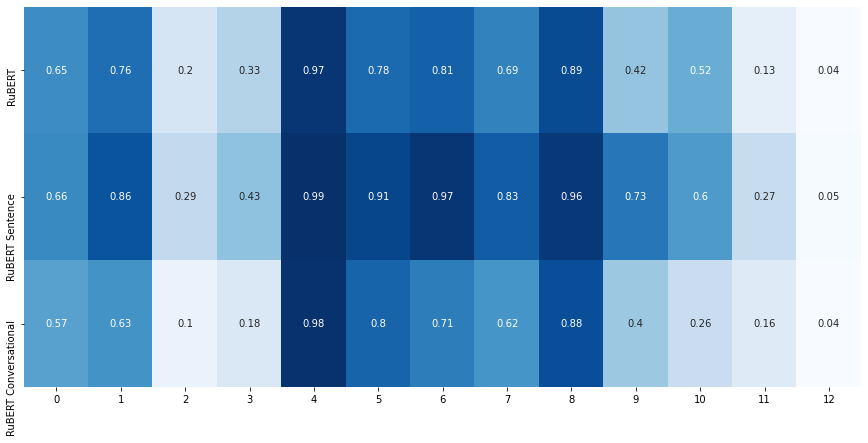

time: 2.45 s (started: 2021-05-20 14:22:43 +03:00)


In [223]:
f, axes = plt.subplots(1, 1, figsize=(15, 7))
axes = sns.heatmap(results_df, annot=True, cmap='Blues', cbar=False)

## 3CosAvg

In [345]:
RuBERT_scores_3CosAvg

[0.8148148148148148,
 0.8292682926829268,
 0.3076923076923077,
 0.4444444444444444,
 0.99,
 0.9464285714285714,
 0.9818181818181818,
 0.8,
 0.9701492537313433,
 0.6333333333333333,
 0.8,
 0.08695652173913043,
 0.043478260869565216]

time: 16 ms (started: 2021-05-20 16:59:38 +03:00)


In [346]:
RuBERT_sentence_scores_3CosAvg

[0.8518518518518519,
 0.975609756097561,
 0.3076923076923077,
 0.5185185185185185,
 1.0,
 0.9821428571428571,
 1.0,
 0.8909090909090909,
 1.0,
 0.8333333333333334,
 0.84,
 0.391304347826087,
 0.043478260869565216]

time: 0 ns (started: 2021-05-20 16:59:38 +03:00)


In [347]:
RuBERT_Conversational_scores_3CosAvg

[0.9259259259259259,
 0.7804878048780488,
 0.15384615384615385,
 0.3333333333333333,
 1.0,
 0.9285714285714286,
 0.7818181818181819,
 0.7090909090909091,
 0.9701492537313433,
 0.6333333333333333,
 0.28,
 0.2608695652173913,
 0.043478260869565216]

time: 0 ns (started: 2021-05-20 16:59:39 +03:00)


In [348]:
RuBERT_scores_rouned = [ round(elem, 2) for elem in RuBERT_scores_3CosAvg ]
RuBERT_sentence_scores_rouned = [ round(elem, 2) for elem in RuBERT_sentence_scores_3CosAvg ]
RuBERT_Conversational_scores_rouned = [ round(elem, 2) for elem in RuBERT_Conversational_scores_3CosAvg ]

time: 0 ns (started: 2021-05-20 17:01:01 +03:00)


In [349]:
results_df_3CosAvg = pd.DataFrame()

results_df_3CosAvg = results_df_3CosAvg.append(pd.Series(RuBERT_scores_rouned),ignore_index=True)
results_df_3CosAvg = results_df_3CosAvg.append(pd.Series(RuBERT_sentence_scores_rouned),ignore_index=True)
results_df_3CosAvg = results_df_3CosAvg.append(pd.Series(RuBERT_Conversational_scores_rouned),ignore_index=True)

results_df_3CosAvg.index = ['RuBERT', 'RuBERT Sentence', 'RuBERT Conversational']

time: 47 ms (started: 2021-05-20 17:01:02 +03:00)


In [352]:
results_df_3CosAvg

,0,1,2,3,4,5,6,7,8,9,10,11,12
RuBERT,0.81,0.83,0.31,0.44,0.99,0.95,0.98,0.80,0.97,0.63,0.80,0.09,0.04
RuBERT Sentence,0.85,0.98,0.31,0.52,1.00,0.98,1.00,0.89,1.00,0.83,0.84,0.39,0.04
RuBERT Conversational,0.93,0.78,0.15,0.33,1.00,0.93,0.78,0.71,0.97,0.63,0.28,0.26,0.04


time: 47 ms (started: 2021-05-20 17:01:13 +03:00)


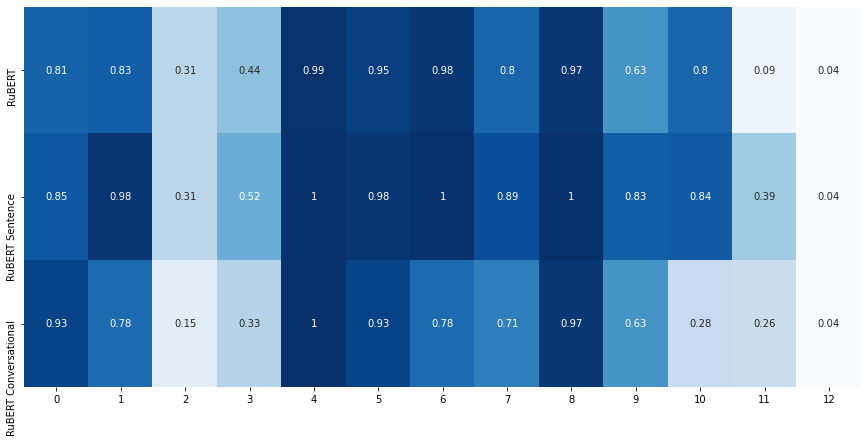

time: 328 ms (started: 2021-05-20 17:01:14 +03:00)


In [353]:
f, axes = plt.subplots(1, 1, figsize=(15, 7))
axes = sns.heatmap(results_df_3CosAvg, annot=True, cmap='Blues', cbar=False)

# Сохраним результаты

In [354]:
results_df.to_csv('bert_results_3CosAdd', sep='\t')

time: 687 ms (started: 2021-05-20 17:09:31 +03:00)


In [355]:
results_df_3CosAvg.to_csv('bert_results_3CosAvg', sep='\t')

time: 31 ms (started: 2021-05-20 17:09:32 +03:00)


In [ ]:
adj-NOTadj.txt
country-adjective.txt
country-language.txt
country-money.txt
singular-plural.txt
verb-noun.txt
verb-noun_3.txt
verb_noun_2.txt
мужской род - женский род.txt
прилагательное-наречие_2.txt
прилагательное-сравнительная степень.txt
столица-страна.txt
столица-страна_2.txt